In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 60

In [3]:
#utils.py is where all our custorm functions live is we set an autoreload on it.
%aimport utils 
from utils import *

# The data

In [4]:
df_all = pd.read_excel('all data v3.xlsx', 'iLab data.txt', index_col=None, na_values=['NA'])

### Preparing a test sample
Let's first use a particular session as a test case. We extract only the data relevant to that case

In [5]:
df_test = prepare_session(df_all,'L-2567b17a:120eda25685:-8000')

After removin 'incorrect' actions, we are left with 212 rows out of 285


# A first plot

In [6]:
colors = {"Now try working on this new example":"#252525",
         "intuition": "#bdbdbd",
         "submit": "#969696",
         "evaluation": "#737373",
         "checkIntuition": "#525252",
         'Median': "#33a02c",
         'Average': "#6a3d9a",
         'Sum': "#1f78b4",
         'all': "#ff7f00",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 'Median': 'Cleaned method 1',
                 'Average': 'Cleaned method 1',
                 'Sum': 'Cleaned method 1',
                 'all': 'Cleaned method 1',
                }
function_to_use = {}
to_plot = ["intuition",'Median','Average','Sum','all',"submit","evaluation","checkIntuition"]

In [7]:
def plot(df,to_plot,colors, column_to_use, function_to_use):
    fig = plt.figure(figsize=(18,9))
    ax = plt.subplot()
    spacing =10
    pos = 0
    max_time = 0
    actions = list(reversed(to_plot))
    black = '#252525'
    for i,action in enumerate(actions):
        if action == "":
            cases = all_cases(df)
            for case,coords in all_cases(df).items():
                left = [float(x) for x in case[0].split(" ")]
                right = [float(x) for x in case[1].split(" ")]
                ymax = max(max(left),max(right))
                ymin = min(min(left),min(right))
                Xl = [coords[0]+30]*len(left)
                Yl = [l/(ymax)*(spacing-2.5)+1+pos for l in left]
                Xr = [coords[0]+30+20]*len(right)
                Yr = [r/(ymax)*(spacing-2.5)+1+pos for r in right]
                ax.plot(Xl,Yl,'.',color='white',markersize=14)
                ax.plot(Xr,Yr,'.',color='white',markersize=14)
        if action in column_to_use.keys():
            action_use = action_usage(df,column_to_use[action],action)
        else:
            action_use = function_to_use[action](df)
        if action_use:
            max_time = max(max_time,sum(action_use[-1]))
            ax.broken_barh(action_use,(pos,spacing),facecolors=colors[action],alpha=1,linewidth=0)
        pos += spacing

        
    ax.text(180,-5,'solution 1',fontsize=12)
#     #Add horizontal bar
#     ax.broken_barh([(0,ax.get_xlim()[1])],((len(actions))*spacing,spacing),facecolors='white',alpha=1,linewidth=0)

    #Add new case bar
    new_case = "Now try working on this new example"
    action_use = action_usage(df,column_to_use[new_case],new_case)
    case_use = [(x,3) for (x,y) in action_use]+[(0,3)]
    max_time = max(max_time,sum(action_use[-1]))
    ax.broken_barh(case_use,(0,(len(actions))*spacing),facecolors=black,alpha=1,linewidth=0)

    ax.set_xlabel('minutes in activity')
    ax.set_xticks(range(0,int(max_time),60*5))
    ax.set_xticklabels([str(x/60)+'' for x in range(0,int(max_time),60*5)])
    ax.set_yticks(range(spacing/2,len(actions)*spacing,spacing))
    ax.set_yticklabels(actions)
    ax.grid(True)
    plt.show()

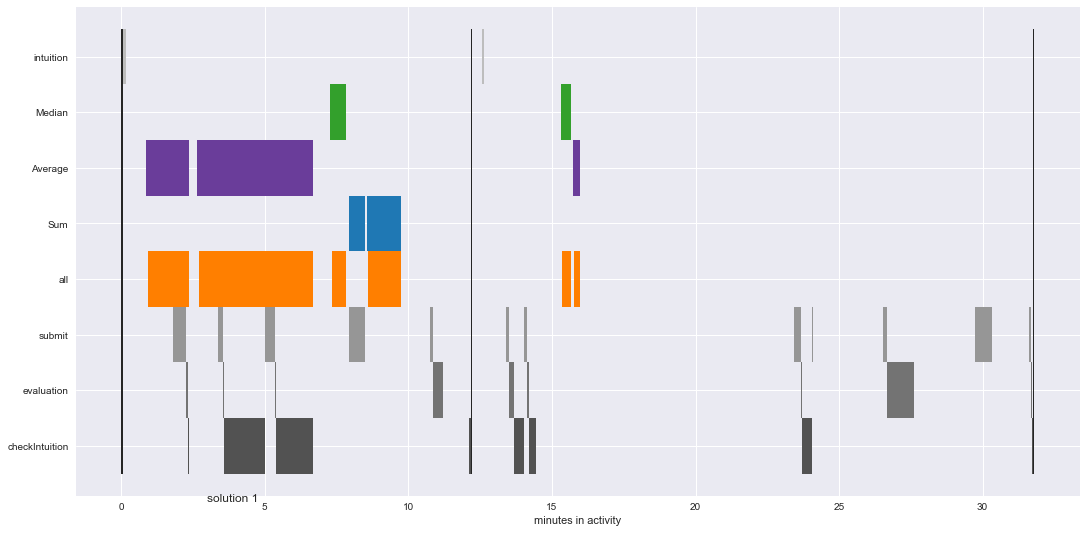

In [8]:
plot(df_test,to_plot,colors, column_to_use, function_to_use)

The black vertical bar in the graph shows when a "new case" is presented

# The actual plot we want

## Add extrapolated range

In [9]:
def regex_extrapolated_range(case_max1,case_min1,case_max2,case_min2):
    pattern = "(?:st\d+ {0} \- {1} st\d+ {2} \- {3}|st\d+ {2} \- {3} st\d+ {0} \- {1}) st3 Step[12] [x\+\-\\\\] Step[12]".format(case_max1,case_min1,case_max2,case_min2)
    return pattern

def extrapolated_range_usage(df):
    usage = []
    cases = all_cases(df)
    for case,coords in cases.items():
        start = coords[0]
        end = coords[1]
        
        lcase = case[0].split(" ")
        rcase = case[1].split(" ")
        lcase.sort()
        rcase.sort()
        
        #find min and maxes of cases for the regex
        lmin1,lmin2,lmax2,lmax1 = lcase[0],lcase[1],lcase[-2],lcase[-1]
        rmin1,rmin2,rmax2,rmax1 = rcase[0],rcase[1],rcase[-2],rcase[-1]
        
        #get all times that the range is used somewhere the method
        range1 = action_usage(df,'Cleaned method 1',regex_extrapolated_range(lmax1,lmin1,lmax2,lmin2))
        range2 = action_usage(df,'Cleaned method 2',regex_extrapolated_range(rmax1,rmin1,rmax2,rmin2))

#         print case, coords[0], coords[0]+coords[1]
#         print "rangel1:", regex_extrapolated_range(lmin1,lmax1)
#         print "rangel2:", regex_extrapolated_range(lmin2,lmax2)
#         print "ranger1:", regex_extrapolated_range(rmin1,rmax1)
#         print "ranger2:", regex_extrapolated_range(rmin2,rmax2)
        
        # and keep only the times that fall within the current case
        range1_for_case = intersect_usage(range1,[coords])
        range2_for_case = intersect_usage(range2,[coords])

        # Merge when it's used on both cases
        usage.extend(clean_coords(merge_usage(range1_for_case,range2_for_case)))

    usage.sort()
    return usage

extrapolated_range_usage(df_test)

[(1261.0, 185.0)]

## Adding in count gaps

In [10]:
df_gaps = prepare_session(df_all,'L-10f11766:120ecd4f63a:-8000')

After removin 'incorrect' actions, we are left with 207 rows out of 288


In [11]:
def regex_count_gaps(gapvalues):
    pattern = "st\d+ Count( choose...)?[( {0})]+".format(')( '.join(gapvalues))
#     print pattern
    return pattern

def count_gaps_usage(df):
    usage = []
    cases = all_cases(df)
    for case,coords in cases.items():
        start = coords[0]
        end = coords[1]
        
        lcase = case[0].split(" ")
        rcase = case[1].split(" ")
        lcase.sort()
        rcase.sort()
        
        #get gap values for the regex
        gapvalues_left = set(range( int(min(lcase)) , int(max(lcase)) )) - set([int(x) for x in lcase]) 
        gapvalues_right = set(range( int(min(rcase)) , int(max(rcase)) )) - set([int(x) for x in rcase]) 
        
        
#         print lcase,  set([int(str(x)) for x in lcase])
#         print 'gap', gapvalues_left 
#         print rcase
#         print 'gap', gapvalues_right
#         print '\n'
        
        #get all times that the range is used somewhere the method
        range1 = action_usage(df,'Cleaned method 1',regex_count_gaps([str(x) for x in gapvalues_left]))
        range2 = action_usage(df,'Cleaned method 2',regex_count_gaps([str(x) for x in gapvalues_right]))

#         print case, coords[0], coords[0]+coords[1]
#         print "rangel1:", regex_count_gaps(lmin1,lmax1)
#         print "rangel2:", regex_count_gaps(lmin2,lmax2)
#         print "ranger1:", regex_count_gaps(rmin1,rmax1)
#         print "ranger2:", regex_count_gaps(rmin2,rmax2)
        
        # and keep only the times that fall within the current case
        range1_for_case = intersect_usage(range1,[coords])
        range2_for_case = intersect_usage(range2,[coords])

        # Merge when it's used on both cases
        usage.extend(clean_coords(merge_usage(range1_for_case,range2_for_case)))

    usage.sort()
    return usage

count_gaps_usage(df_gaps)

utils.py:129: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return zip(df[df[column].str.contains(action,na=False)]['Time_seconds'],df[df[column].str.contains(action,na=False)]['Duration'])


[(627.0, 9.0), (1294.0, 160.0)]

## Adding cases

In [12]:
def case_usage(df):
    usage = []
    cases = all_cases(df)
    for case,coords in cases.items():
        start = coords[0]
        end = 30+20+30
        usage.append((start,end))
    return usage

In [13]:
colors = {"":"black",
         "Now try working on this new example":"#252525",
         "intuition": "#969696",
         "single value": "red",
         'Central tendency': "#33a02c",
         'extrapolated range': "#6a3d9a",
#          'Average': "#6a3d9a",
#          'Sum': "#1f78b4",
          'Count gaps': "#1f78b4",
          'range': "#1f78b4",
         'all': "#ff7f00",
         'evaluation steps': "#525252",
        }
column_to_use = {"Now try working on this new example":"Feedback Text",
                 "intuition": "Selection",
                 "submit": "Selection",
                 "evaluation": "Selection",
                 "checkIntuition": "Selection",
                 'Median': 'Cleaned method 1',
                 'Average': 'Cleaned method 1',
                 'Sum': 'Cleaned method 1',
                 'all': 'Cleaned method 1',
                }

function_to_use = {"":case_usage,
                   "single value":single_value_usage,
                   "Central tendency":central_tendency_usage,
                   "range":range_usage,
                   "extrapolated range":extrapolated_range_usage,
                   "Count gaps":count_gaps_usage,
                   "evaluation steps":evaluation_steps_usage}

to_plot = ["","intuition",'single value','Central tendency','range',"extrapolated range","Count gaps","evaluation steps"]

### Session with gap counting

utils.py:145: FutureWarning: 'as_indexer' keyword was specified but is ignored (match now returns a boolean indexer by default), and will be removed in a future version.
  return zip(df[df[column].str.match(action,as_indexer=True)]['Time_seconds'],df[df[column].str.match(action,as_indexer=True)]['Duration'])


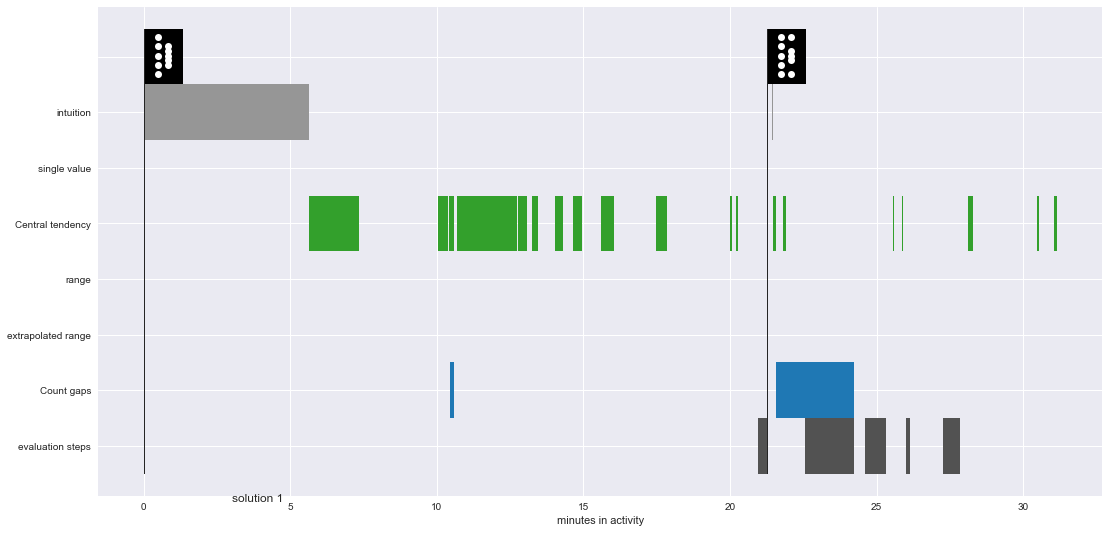

In [14]:
plot(df_gaps,to_plot,colors, column_to_use, function_to_use)

### Session with range and extrapolated range

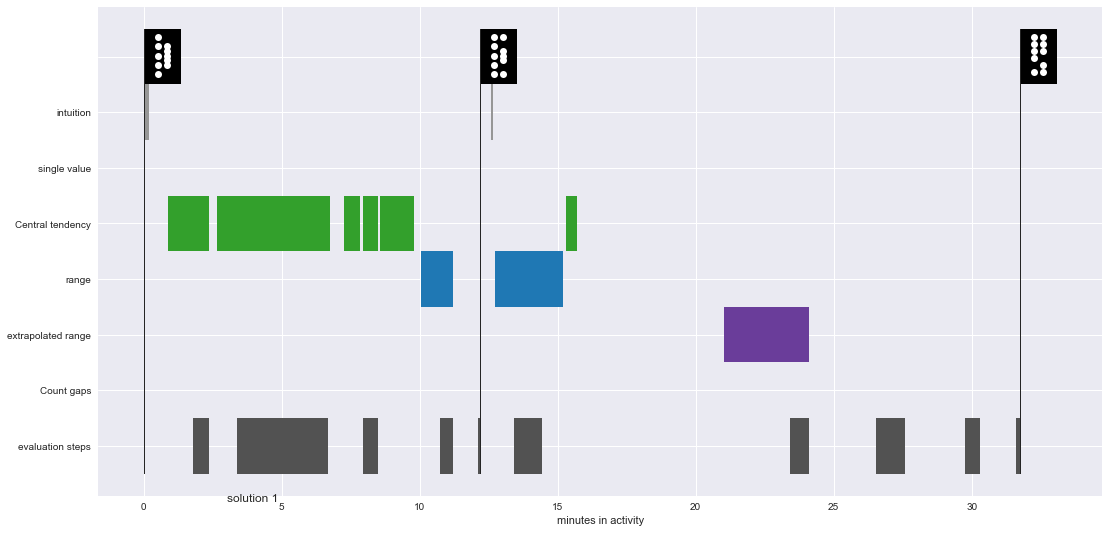

In [15]:
plot(df_test,to_plot,colors, column_to_use, function_to_use)

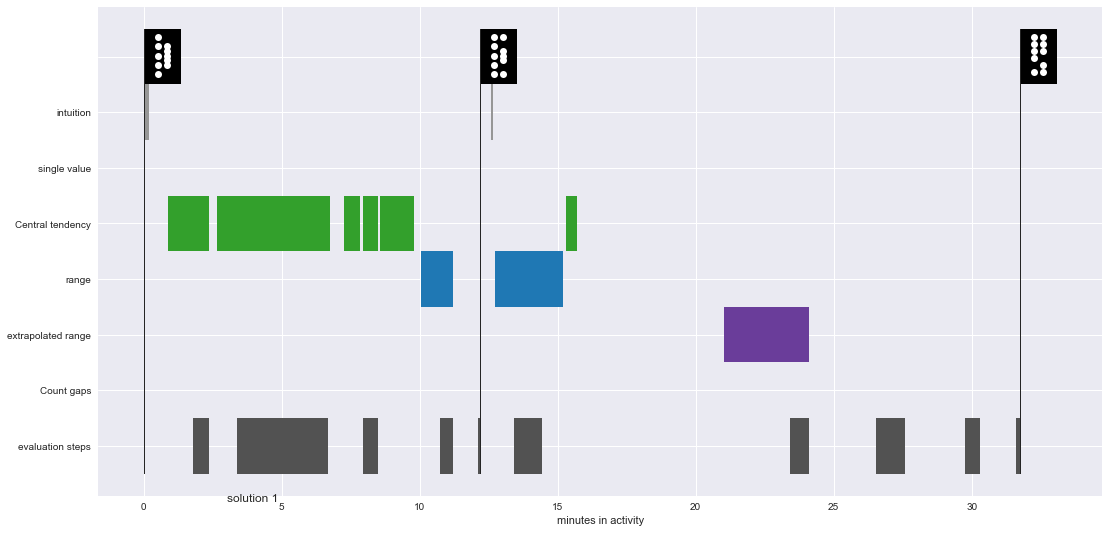

In [16]:
plot(df_test,to_plot,colors, column_to_use, function_to_use)

### TODO
Ordered in some kind of general priority (in terms of need of feedback and desired feature)
* start implementing categories that are under “option 4” in the coding document (see copy below from May 29th)
* display method at "max", after a submit or delete all/reset
* add case data to graph
* display method at "max", after a submit or delete all/reset
* merge evaluation and checkintuition
* Indicate when current method could be used to “crack” or solve the contrasting cases. (‘when it works’) => correct order. 

### Overall graph structure:
Row 1: intuition
Rows 2-n: methods
Plot “build” events (any click in that part of the interface).
Below, show the method in writing.
Row n+1: Submit
Row n+2: Evaluation (merge Evaluate, Check Intuition).
Later consider merging “submit” into this. 
 
Plot building events, not durations 
Pauses become gaps. 



#### Categories
1. single value -DONE
* Central tendency, ready made -DONE
* Combination of ready made, random
* Range 6 - 1
* Count gaps (if numbers are 1 4 4 6)
    * click all empty points within range - 2 3 5
    * click all empty points within the largest gap - 2 3
* Extrapolated range
    * Inner range 4-4 - single step method
    * Any method that uses more than extreme values, and some form of subtraction. 
        * Recursive range (6-1) +/- (4-4)
        * All pairwise ranges (6-1, 6-4, 4-4, 4-1)
* extrapolated range + count all
* Canonical
